In [35]:
import os
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil
import pytesseract as pt

In [5]:
path = glob('./data/number-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [6]:
df = pd.DataFrame(labels_dict)
df.to_csv('./labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./data/number-plate-detection/images\N1.xml,1093,1396,645,727
1,./data/number-plate-detection/images\N100.xml,134,301,312,350
2,./data/number-plate-detection/images\N101.xml,31,139,128,161
3,./data/number-plate-detection/images\N102.xml,164,316,216,243
4,./data/number-plate-detection/images\N103.xml,813,1067,665,724


In [7]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'./data/number-plate-detection/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,./data/number-plate-detection/images\N1.xml,1093,1396,645,727,./data/number-plate-detection/images/N1.jpeg,1920,1080
1,./data/number-plate-detection/images\N100.xml,134,301,312,350,./data/number-plate-detection/images/N100.jpeg,450,417
2,./data/number-plate-detection/images\N101.xml,31,139,128,161,./data/number-plate-detection/images/N101.jpeg,249,239
3,./data/number-plate-detection/images\N102.xml,164,316,216,243,./data/number-plate-detection/images/N102.jpeg,478,395
4,./data/number-plate-detection/images\N103.xml,813,1067,665,724,./data/number-plate-detection/images/N103.jpeg,1800,1200


In [8]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,./data/number-plate-detection/images\N1.xml,1093,1396,645,727,./data/number-plate-detection/images/N1.jpeg,1920,1080,0.648177,0.635185,0.157812,0.075926
1,./data/number-plate-detection/images\N100.xml,134,301,312,350,./data/number-plate-detection/images/N100.jpeg,450,417,0.483333,0.793765,0.371111,0.091127
2,./data/number-plate-detection/images\N101.xml,31,139,128,161,./data/number-plate-detection/images/N101.jpeg,249,239,0.341365,0.604603,0.433735,0.138075
3,./data/number-plate-detection/images\N102.xml,164,316,216,243,./data/number-plate-detection/images/N102.jpeg,478,395,0.502092,0.581013,0.317992,0.068354
4,./data/number-plate-detection/images\N103.xml,813,1067,665,724,./data/number-plate-detection/images/N103.jpeg,1800,1200,0.522222,0.578750,0.141111,0.049167


<p id="part35"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">8.2 DATA PREPARATION</span>

One of the major challenges in the training of YOLO is hardware itself. YOLO requires a fast-processing chip used to get trained. It is extremely difficult to train the YOLO in normal CPUs. Firstly, we have to clone YOLOV5 to our work space. You can find it [here](https://github.com/ultralytics/yolov5) and install all requirements. Make sure you in right folder type as below, let's do it.

In [9]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


In [21]:
!pip install -r ./yolov5/requirements.txt

  Using cached PyYAML-6.0.1-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached torch-2.2.1-cp310-cp310-win_amd64.whl.metadata (26 kB)
  Using cached torchvision-0.17.1-cp310-cp310-win_amd64.whl.metadata (6.6 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
     ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
     ---------------------------------------- 40.3/40.3 kB 1.9 MB/s eta 0:00:00
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/195.4 kB ? eta -:--:--
   ------------------------------

In [15]:
def check_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Created folder: ", path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        print("Already exists: ", path)
        
path =  './yolov5/data_images/'
check_folder(path)

Created folder:  ./yolov5/data_images/


In [16]:
path =  './yolov5/data_images/test/'
check_folder(path)

Created folder:  ./yolov5/data_images/test/


In [17]:
path =  './yolov5/data_images/train/'
check_folder(path)

Created folder:  ./yolov5/data_images/train/


In [18]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [19]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

<p id="part36"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">8.3 TRAINING YOLO</span>

Next step is basically train model. It could take time be ready for it. You can use Kaggle or GoogleColab for it. We already set out data.yaml file, lets us give path to it and train model. Below you will find code to cleare you GPU(It helped me a lot and will save you time.)

In [23]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 15% |  6% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 27% |  8% |


In [24]:
!python ./yolov5/train.py --data ./data/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

train: weights=yolov5\yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./data/number-plate-detection/data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5\data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5\runs\train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-294-gdb125a20 Python-3.10.6 torch-2.2.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8

When model trained, we need to save our it in order to use it at OCR in onnx format as below:

In [25]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...






   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/14.3 MB 3.3 MB/s eta 0:00:05
   - -------------------------------------- 0.5/14.3 MB 6.8 MB/s eta 0:00:03
   -- ------------------------------------- 0.8/14.3 MB 6.1 MB/s eta 0:00:03
   --- ------------------------------------ 1.3/14.3 MB 7.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.6/14.3 MB 7.1 MB/s eta 0:00:02
   ---- ----------------------------------- 1.6/14.3 MB 6.0 MB/s eta 0:00:03
   ------ --------------------------------- 2.2/14.3 MB 7.1 MB/s eta 0:00:02
   ------ --------------------------------- 2.5/14.3 MB 6.9 MB/s eta 0:00:02
   ------- -------------------------------- 2.7/14.3 MB 6.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.8/14.3 MB 6.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.9/14.3 MB 5.8 MB/

export: data=C:\Users\vuanh\Desktop\Number-plate\yolov5\data\coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5  v7.0-294-gdb125a20 Python-3.10.6 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5\runs\train\Model\weights\best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.2.1+cpu...
TorchScript: export success  0.9s, saved as yolov5\runs\train\Model\weights\best.torchscript (27.2 MB)
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages 

All right, we have successfully safed our model after unzip it. We can notice that there is a model folder.
We can find predicted pictures and we are able to detect the license plate very accurately. There might be the few wrong results, but still our model detects the license plate accurately. PR cow is eventually very  important for me that will tell you the detection rate. We can see that our precision recall tell us that we can able to detect our model with 0.92 Precision and 0.5 mean Average Precision, you can find example of one of val_batch below
<img src= "https://github.com/Asikpalysik/Automatic-License-Plate-Detection/blob/main/Presentation/Notebook15.png?raw=true" width="100%" align="center"  hspace="5%" vspace="5%"/>

<p id="part37"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">8.4 PREDICTING RESULTS FROM YOLO</span>

Let’s do some images settings which is omportant to provide in model construction.  Input settings we need to pass as 640 by 640.

In [30]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640
import plotly.express as px
import matplotlib.pyplot as plt

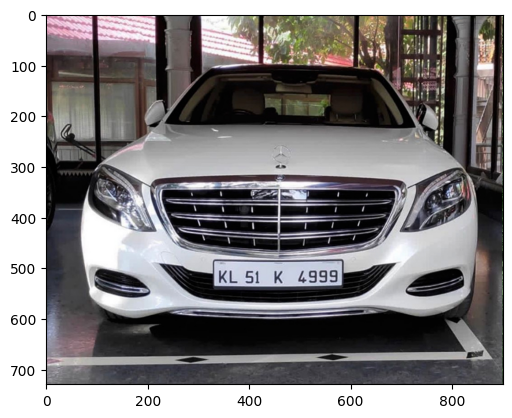

In [31]:
# LOAD THE IMAGE
img = io.imread('./data/number-plate-detection/TEST/TEST.jpeg')

plt.imshow(img)

In [32]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [36]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [37]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [38]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [57]:
# test
pt.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
img = io.imread('./data/number-plate-detection/TEST/whose-number-plate-is-this.jpg')
results = yolo_predictions(img,net)

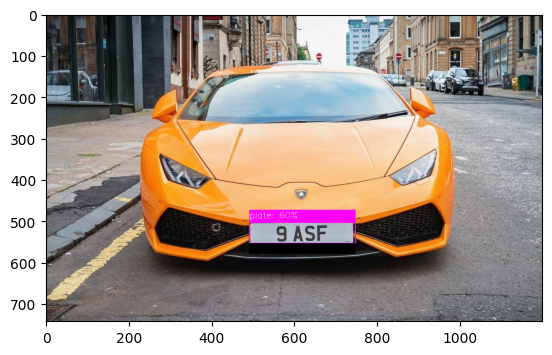

In [58]:
fig = px.imshow(img)
plt.imshow(results)